# Parameter estimation from the broadband light curve assuming red noise 

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import math as mt
import pandas as pd
import seaborn as sb
from pandas import HDFStore
from mpl_toolkits.axes_grid1 import make_axes_locatable

from core import *

In [3]:
fwn = pd.read_hdf('results/pe.h5','bb/wn_nomask')
fwm = pd.read_hdf('results/pe.h5','bb/wn_masked')
frn = pd.read_hdf('results/pe.h5','bb/rn_nomask')
frm = pd.read_hdf('results/pe.h5','bb/rn_masked')

In [4]:
pe = pd.Panel(dict(wn = pd.read_hdf('results/pe.h5','bb/wn_nomask'),
                   wm = pd.read_hdf('results/pe.h5','bb/wn_masked'),
                   rn = pd.read_hdf('results/pe.h5','bb/rn_nomask'),
                   rm = pd.read_hdf('results/pe.h5','bb/rn_masked')))

## Plots 

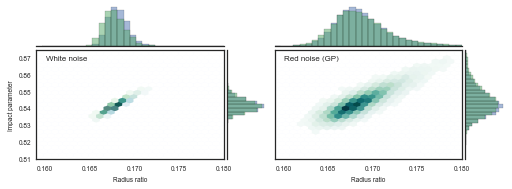

In [5]:
def hexbin2(fig, ax, a1, a2, b1, b2, alim, blim, gs):
    h1 = ax.hexbin(a1, b1, extent=(alim[0],alim[1],blim[0],blim[1]), 
                   gridsize=gs, cmap=plt.cm.Blues)
    h2 = ax.hexbin(a2, b2, extent=(alim[0],alim[1],blim[0],blim[1]), 
                   gridsize=gs, cmap=plt.cm.Greens)
    fig.canvas.draw()
    fc = h1.get_facecolors() + h2.get_facecolors()
    fc *= 0.5
    fc[fc[:,:3].sum(1)>2.9,:] = array([1,1,1,1])
    h2.set_facecolors(fc)
    fig.canvas.draw()
    ax.set_xlim(*klim)
    ax.set_ylim(*blim)
   
cn, cm = cp[2], cp[3]
klim = (0.159,0.18)
blim = (0.810,0.875)
msize, mpad = 0.55, 0.05

with sb.plotting_context('paper', rc=rc_paper):
    fig, axs = subplots(1,2, figsize=(AAPGW,0.75*AAOCW), sharey=True, sharex=True)
    divs = [make_axes_locatable(ax) for ax in axs]
    axhys = [div.append_axes('top',   size=msize, pad=mpad, sharex=axs[i]) for i,div in enumerate(divs)]
    axhxs = [div.append_axes('right', size=msize, pad=mpad, sharey=axs[i]) for i,div in enumerate(divs)]

    hexbin2(fig, axs[0], fwn.k, fwm.k, fwn.b, fwm.b, klim, blim, 25)
    hexbin2(fig, axs[1], frn.k, frm.k, frn.b, frm.b, klim, blim, 25)

    axhys[0].hist(fwn.k,  bins=30, range=klim, alpha=0.5, normed=True, fc=cn)
    axhys[0].hist(fwm.k,  bins=30, range=klim, alpha=0.5, normed=True, fc=cm)
    axhxs[0].hist(fwn.b,  bins=30, range=blim, alpha=0.5, orientation='horizontal', normed=True, fc=cn)
    axhxs[0].hist(fwm.b,  bins=30, range=blim, alpha=0.5, orientation='horizontal', normed=True, fc=cm)
    axhys[1].hist(frn.k,  bins=30, range=klim, alpha=0.5, normed=True, fc=cn)
    axhys[1].hist(frm.k,  bins=30, range=klim, alpha=0.5, normed=True, fc=cm)
    axhxs[1].hist(frn.b,  bins=30, range=blim, alpha=0.5, orientation='horizontal', normed=True, fc=cn)
    axhxs[1].hist(frm.b,  bins=30, range=blim, alpha=0.5, orientation='horizontal', normed=True, fc=cm)

    setp(axhys[0].get_yticklabels()+axhys[1].get_yticklabels(), visible=False)
    setp(axhys[0].get_xticklabels()+axhys[1].get_xticklabels(), visible=False)
    setp(axhxs[0].get_yticklabels()+axhxs[1].get_yticklabels(), visible=False)
    setp(axhxs[0].get_xticklabels()+axhxs[1].get_xticklabels(), visible=False)

    [sb.despine(ax=a, left=True) for a in axhys]
    [sb.despine(ax=a, bottom=True) for a in axhxs]

    axs[0].text(0.05, 0.9, 'White noise', size=8, transform=axs[0].transAxes)
    axs[1].text(0.05, 0.9, 'Red noise (GP)', size=8, transform=axs[1].transAxes)

    setp(axs[0], xlim=(0.159,0.18), ylim=blim)
    setp(axhxs, ylim=blim)
    setp(axs[0], xlabel='Radius ratio', ylabel='Impact parameter')
    setp(axs[1], xlabel='Radius ratio')
    fig.tight_layout()
    fig.savefig('plots/pub_white_k_and_b.pdf')

In [6]:
def get_range(p):
    pn = percentile(dfn[p], [0.25,99.75])
    pm = percentile(dfm[p], [0.25,99.75])
    return [min(pn[0],pm[0]),max(pn[1],pm[1])]

In [7]:
dfn = fwn
dfm = fwm 

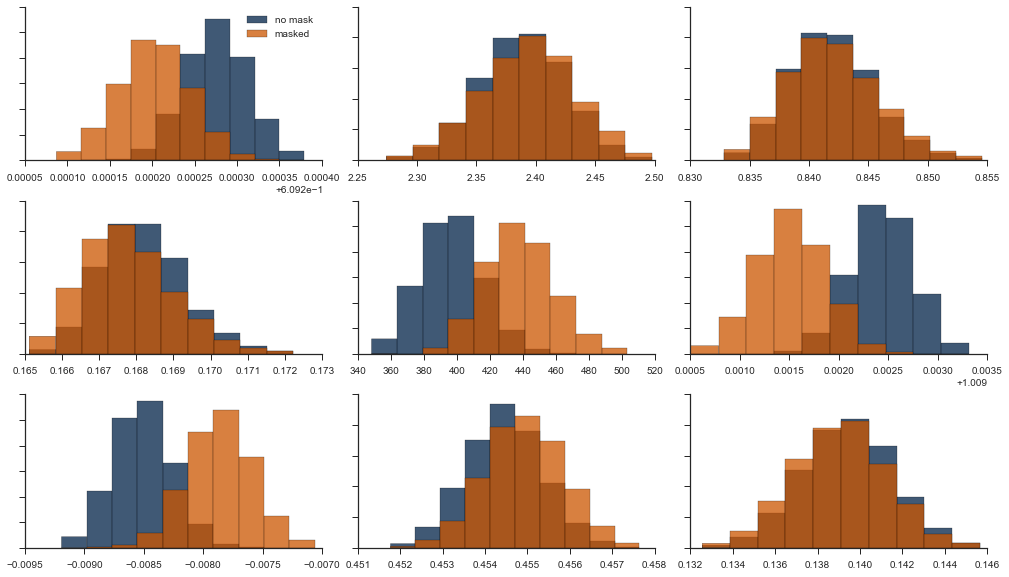

In [8]:
dfn['e_ppm'] = 1e6*dfn.e
dfm['e_ppm'] = 1e6*dfm.e

pars = 'tc rho b k e_ppm c x u v'.split()
cp = sb.color_palette()

with sb.axes_style('ticks'):
    fig,axs = subplots(3,3,figsize=(14,8))
    for i,p in enumerate(pars):
        rng = get_range(p)
        dfn[p].hist(ax=axs.flat[i], fc=cp[0], range=rng, label='no mask', grid=False, alpha=0.75)
        dfm[p].hist(ax=axs.flat[i], fc=cp[1], range=rng, label='masked', grid=False, alpha=0.75)
        setp(axs.flat[i].get_yticklabels(), visible=False)
    axs.flat[0].legend()
    sb.despine(fig)
    fig.tight_layout()

In [9]:
def estimate(d):
    p = array(percentile(d, [50,16,84]))
    return p[0], abs(p[1:]-p[0]).mean()

estimate(pe.wn.tc)

(nan, nan)

In [10]:
time       = lpfw.lpf.time
flux_o     = lpfw.lpf.flux.ravel()
flux_m     = est_model[0,:]
residuals  = flux_o - flux_m

NameError: name 'lpfw' is not defined

In [ ]:
fig,ax = subplots(1,1, figsize=(AAOCW,0.65*AAOCW))
ax.plot(time, flux_o, '.', c=c_bo, alpha=0.25, ms=5.5)
ax.plot(time, flux_o, '.', c=c_bo, alpha=0.5, ms=4.5, markeredgecolor=c_bo)
ax.fill_between(time, *est_model[1:,:], alpha=0.2)
ax.plot(time, est_baseline[0,:], '--', c=c_ob, lw=1)
ax.plot(time, est_model[0,:], '-', c=c_ob, alpha=0.5, lw=1)
ax.axhline(0.97, ls='-', alpha=0.5, c=c_bo)
ax.plot(time, residuals+0.97, '-', c=c_ob, drawstyle='steps-mid', lw=1)
setp(ax, xlim=df.time[[0,224]], ylabel='Normalised flux', xlabel='JD - {:d} [d]'.format(int(df.jd[0])), 
     yticks=[0.97,0.98,0.99,1.0])
fig.tight_layout()
fig.savefig('plots/white_lc_and_model.pdf')

In [ ]:
lpfr.gp.kernel = fcr[0,10]**2*ExpKernel(1./10**fcr[0,11])
lpfr.gp.compute(lpfr.lpf.time, fcr[0,5])

obs,mod,bsl,gpm = [],[],[],[]
for pv in permutation(fcr)[:100]:
    obs.append(lpfr.lpf.normalize_flux(pv).ravel())
    bsl.append(lpfr.lpf.compute_baseline(pv).ravel())
    mod.append(lpfr.lpf.compute_lc_model(pv).ravel())
    gpm.append(lpfr.gp.predict(obs[-1]-mod[-1], time.ravel(), mean_only=True))
obs,mod,bsl,gpm = map(array, [obs,mod,bsl,gpm])

In [ ]:
fig, ax = subplots(1,1, figsize=(AAOCW,0.65*AAOCW))
em1 = array(percentile(mod+gpm, [16,84], 0))
em2 = array(percentile(mod+gpm, [2.5,97.5], 0))
fill_between(time, *em2, alpha=0.15, facecolor=c_ob)
fill_between(time, *em1, alpha=0.25, facecolor=c_ob)
ax.plot(time, median(mod+gpm, 0), c=c_ob, lw=0.5);
ax.plot(time, median(obs,0),'k.', ms=4.5);
ax.plot(time, median(obs,0),'w.', ms=3);
ax.plot(time, median(obs,0)-median(mod+gpm, 0)+0.97, 'k.', ms=3)
setp(ax, xlim=time[[3,-1]], xlabel='JD - 2456846 [d]', ylabel='Normalised flux', 
     yticks=linspace(0.97,1.0,4))
fig.tight_layout()
fig.savefig('plots/white_lc_and_model_gp.pdf')

---
<center> &copy; 2015 <a href="mailto:hannu.parviainen@physics.ox.ac.uk">Hannu Parviainen</a></center>